In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [2]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

def epipolar_SIFT(img1, img2, n_matches):
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    kp_img = cv2.drawKeypoints(img1, kp2, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    #plt.figure(figsize = (10,10))
    #plt.imshow(kp_img)
    bf = cv2.BFMatcher()
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance (i.e. best matches first).
    matches = sorted(matches, key = lambda x:x.distance)
    nb_matches = n_matches

    good = []
    pts1 = []
    pts2 = []

    for m in matches[:nb_matches]:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)

    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

    # We select only inlier points
    pts1 = pts1[mask.ravel() == 1]
    pts2 = pts2[mask.ravel() == 1]
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
    lines1 = lines1.reshape(-1, 3)
    img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)
    img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

    fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
    axs[0, 0].imshow(img4)
    axs[0, 0].set_title('left keypoints')
    axs[0, 1].imshow(img6)
    axs[0, 1].set_title('right keypoints')
    axs[1, 0].imshow(img5)
    axs[1, 0].set_title('left epipolar lines')
    axs[1, 1].imshow(img3)
    axs[1, 1].set_title('right epipolar lines')
    plt.show()

In [3]:
nb_vertical = 6
nb_horizontal = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints_l = [] # 3d point in real world space
imgpoints_l = [] # 2d points in image plane.

images_l = glob.glob('rs/left-*.png')
assert images_l


for fname in images_l:
    img = cv2.imread(fname)
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(img, (nb_vertical,nb_horizontal),  None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints_l.append(objp)

        imgpoints_l.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
        cv2.imshow('img',img)
        cv2.waitKey(50)

cv2.destroyAllWindows()
print(np.asarray(objpoints_l).shape)
print(np.asarray(imgpoints_l).shape)

(76, 54, 3)
(76, 54, 1, 2)


In [4]:
# Arrays to store object points and image points from all the images.
objpoints_r = [] # 3d point in real world space
imgpoints_r = [] # 2d points in image plane.

images_r = glob.glob('rs/right-*.png')
assert images_r


for fname in images_r:
    img = cv2.imread(fname)
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(img, (nb_vertical,nb_horizontal),  None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints_r.append(objp)

        imgpoints_r.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
        cv2.imshow('img',img)
        cv2.waitKey(50)

cv2.destroyAllWindows()
print(np.asarray(objpoints_r).shape)
print(np.asarray(imgpoints_r).shape)

(76, 54, 3)
(76, 54, 1, 2)


In [5]:
ret_l, mtx_l, dist_l, rvecs_l, tvecs_l = cv2.calibrateCamera(objpoints_l, imgpoints_l, gray.shape[::-1], None, None)

In [6]:
ret_r, mtx_r, dist_r, rvecs_r, tvecs_r = cv2.calibrateCamera(objpoints_r, imgpoints_r, gray.shape[::-1], None, None)

In [7]:
img_l = cv2.imread('rs/left-0013.png')
h,  w = img_l.shape[:2]
newcameramtx_l, roi_l = cv2.getOptimalNewCameraMatrix(mtx_l,dist_l,(w,h),1,(w,h))
print (newcameramtx_l)
img_r = cv2.imread('rs/right-0013.png')
h,  w = img_r.shape[:2]
newcameramtx_r, roi_r = cv2.getOptimalNewCameraMatrix(mtx_r,dist_r,(w,h),1,(w,h))
print (newcameramtx_r)

[[366.46530151   0.         325.13526662]
 [  0.         367.27114868 247.98819482]
 [  0.           0.           1.        ]]
[[368.80383301   0.         323.23710906]
 [  0.         369.61532593 246.365414  ]
 [  0.           0.           1.        ]]


Text(0.5, 1.0, 'Undistorted image right')

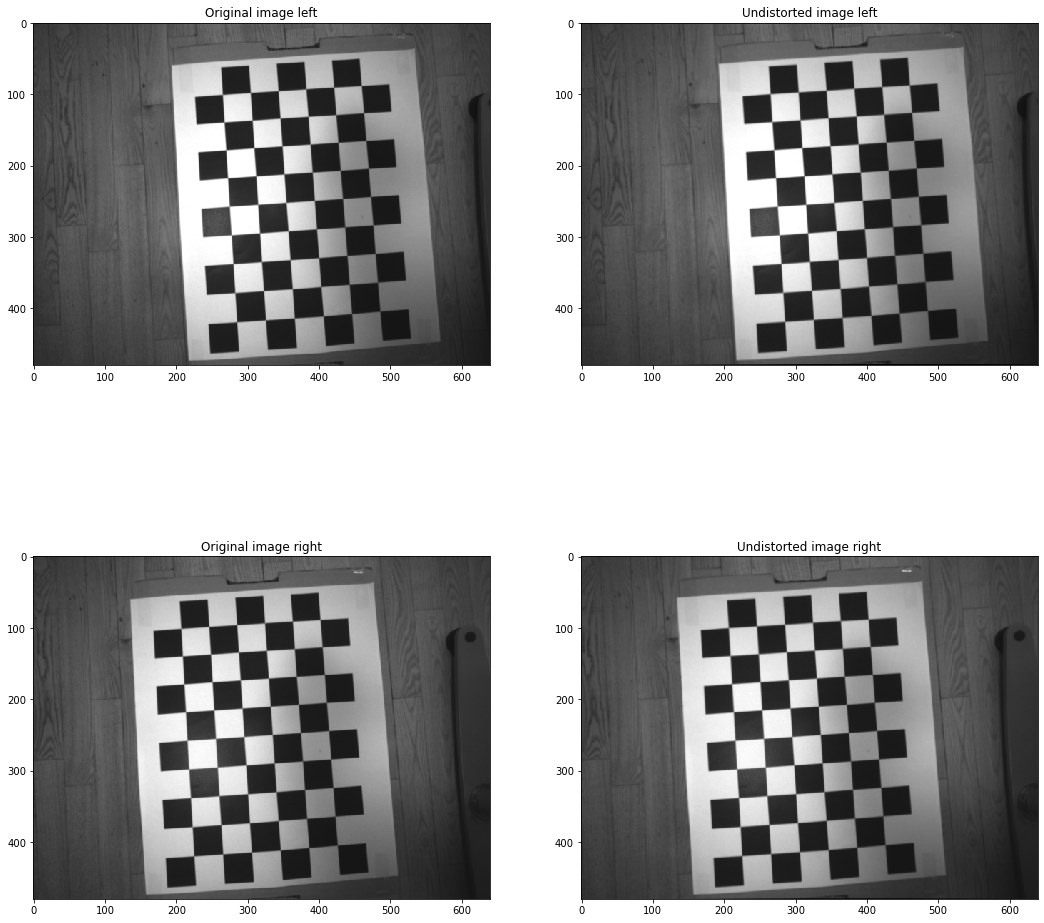

In [8]:
dst_l = cv2.undistort(img_l, mtx_l, dist_l, None, None)
dst_r = cv2.undistort(img_r, mtx_r, dist_r, None, None)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
ax[0, 0].imshow(img_l[...,[2,1,0]])
ax[0, 0].set_title('Original image left')
ax[0, 1].imshow(dst_l[...,[2,1,0]])
ax[0, 1].set_title('Undistorted image left')
ax[1, 0].imshow(img_r[...,[2,1,0]])
ax[1, 0].set_title('Original image right')
ax[1, 1].imshow(dst_r[...,[2,1,0]])
ax[1, 1].set_title('Undistorted image right')

Text(0.5, 1.0, 'Right image')

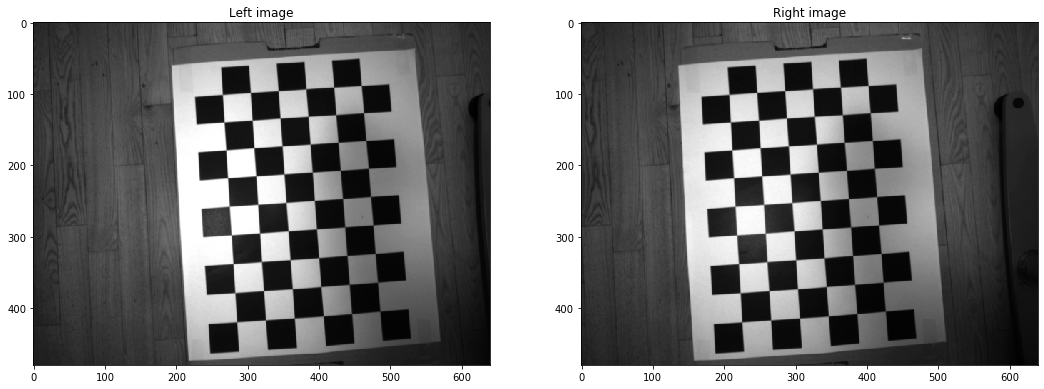

In [9]:
img1 = cv2.imread("rs/left-0013.png", 0)
img2 = cv2.imread("rs/right-0013.png", 0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('Left image')
ax[1].imshow(img2, cmap='gray')
ax[1].set_title('Right image')

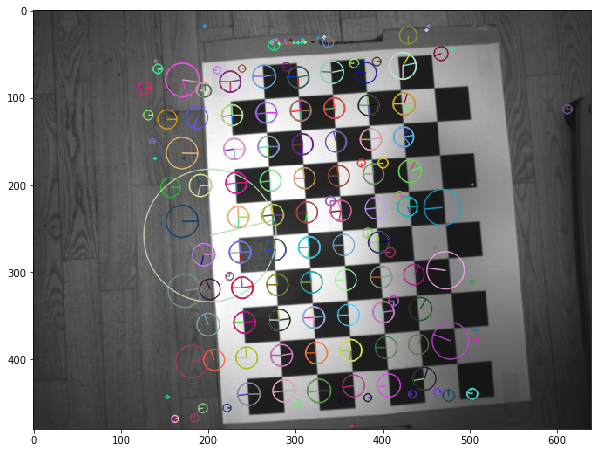

In [10]:
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kp_img = cv2.drawKeypoints(img1, kp2, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
plt.imshow(kp_img)

In [11]:
bf = cv2.BFMatcher()
matches = bf.match(des1,des2)

# Sort them in the order of their distance (i.e. best matches first).
matches = sorted(matches, key = lambda x:x.distance)

nb_matches = 200

good = []
pts1 = []
pts2 = []

for m in matches[:nb_matches]:
    good.append(m)
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
    
"""
Implement findFundamentalMat here:
F, mask = ...
"""
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

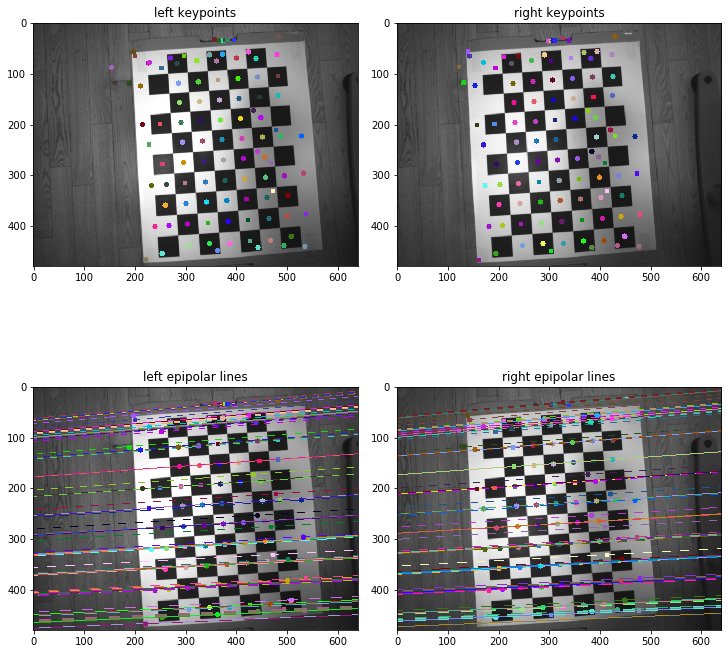

In [12]:
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()

In [13]:
ret, mtx_l, dist_l, mtx_r, dist_r, R, T, E, F = cv2.stereoCalibrate(objpoints_l, imgpoints_l, imgpoints_r, mtx_l, dist_l, mtx_r, dist_r, img1.shape)
#ret, mtx_l, dist_l, mtx_r, dist_r, R, T, E, F = cv2.stereoCalibrate(objp, imgpoints_l, imgpoints_r, mtx_l, dist_l, mtx_r, dist_r, image_size)
R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(mtx_l, dist_l, mtx_r, dist_r, img1.shape, R, T, flags=cv2.CALIB_ZERO_DISPARITY, alpha=0.9 )

Text(0.5, 1.0, 'Right image')

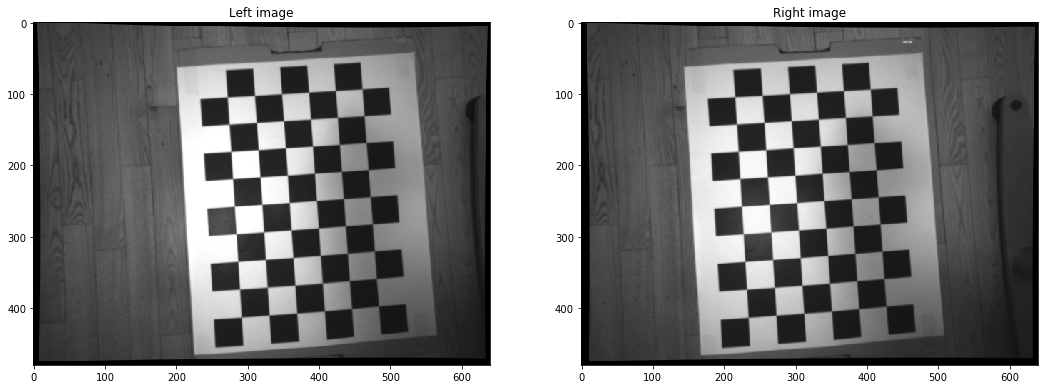

In [39]:
h,  w = img1.shape[:2]
xmap_l, ymap_l = cv2.initUndistortRectifyMap(mtx_l, dist_l, R1, P1, (w,h), cv2.CV_32FC1)
xmap_r, ymap_r = cv2.initUndistortRectifyMap(mtx_r, dist_r, R2, P2, (w,h), cv2.CV_32FC1)

# dst_l = cv2.undistort(img1, mtx_l, dist_l, None, None)
# dst_r = cv2.undistort(img2, mtx_r, dist_r, None, None)

rect_l = cv2.remap(dst_l, xmap_l, ymap_l, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
rect_r = cv2.remap(dst_r, xmap_r, ymap_r, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(rect_l, cmap='gray')
ax[0].set_title('Left image')
ax[1].imshow(rect_r, cmap='gray')
ax[1].set_title('Right image')

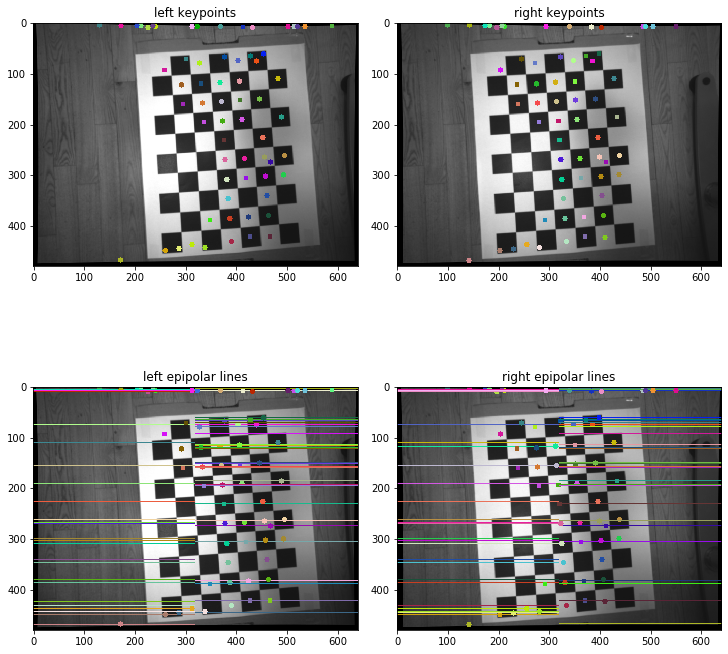

In [42]:
epipolar_SIFT(rect_l, rect_r, 100)